          model    serial_number  smart_9_normalized  smart_9_raw  failure
0  WDC WD60EFRX  WD-WX31DB48X22V                 1.0      78035.0        0
1   ST6000DX000         Z4D00WGP               100.0        869.0        0
2   ST6000DX000         Z4D00YC6                99.0        879.0        0
3   ST6000DX000         Z4D00YS2                99.0        881.0        0
4   ST6000DX000         Z4D029JS               100.0        875.0        0


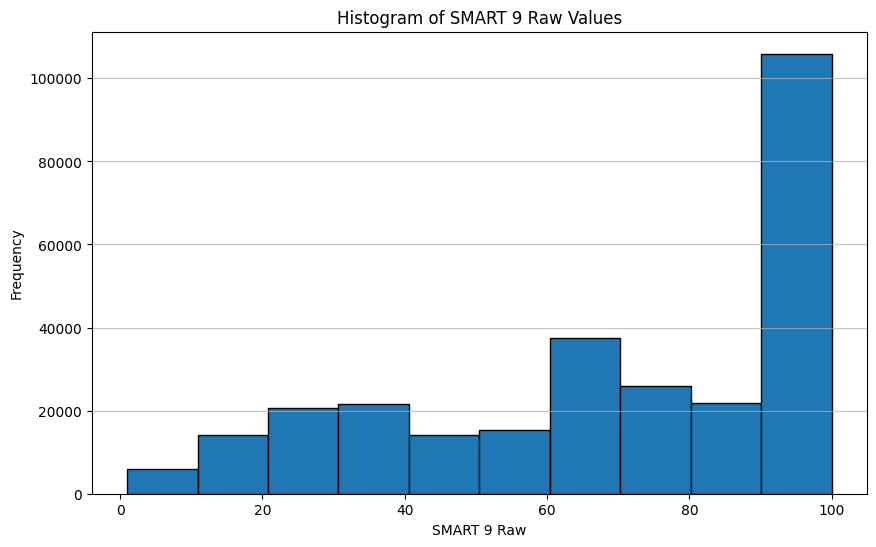

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file into a DataFrame
df = pd.read_csv('D:/OneDrive/Desktop/2024-04-01.csv')

# Extract specific columns
selected_columns = df[['model', 'serial_number', 'smart_9_normalized', 'smart_9_raw', 'failure']]

# Display the extracted columns
print(selected_columns.head())

# Plotting the histogram of 'smart_9_raw'
plt.figure(figsize=(10, 6))
plt.hist(df['smart_9_normalized'], bins=10, edgecolor='black')  # Adjust bins as needed
plt.title('Histogram of SMART 9 Raw Values')
plt.xlabel('SMART 9 Raw')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

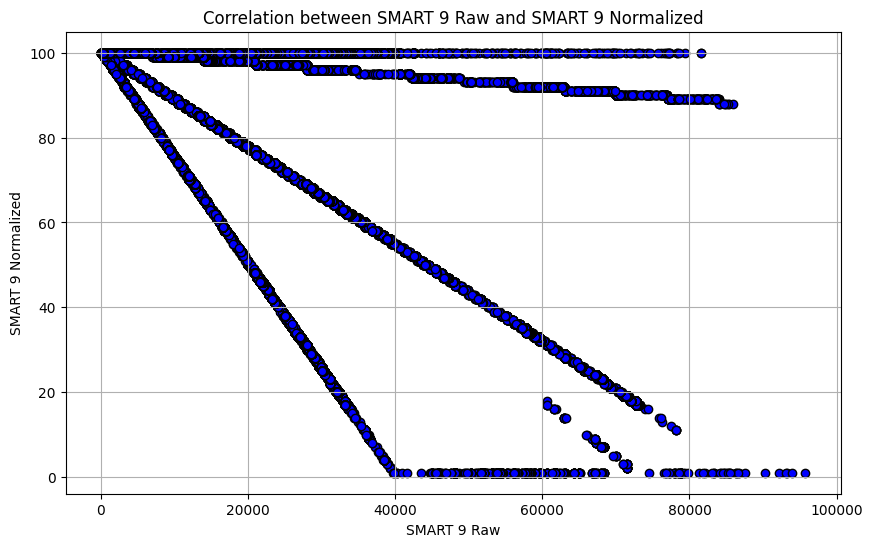

In [6]:
# Plotting scatter plot to show correlation
plt.figure(figsize=(10, 6))
plt.scatter(df['smart_9_raw'], df['smart_9_normalized'], color='blue', edgecolor='black')
plt.title('Correlation between SMART 9 Raw and SMART 9 Normalized')
plt.xlabel('SMART 9 Raw')
plt.ylabel('SMART 9 Normalized')
plt.grid(True)
plt.show()

In [ ]:
unique_models = df['model'].unique()

# Plotting correlations for each model
plt.figure(figsize=(15, 10))
for i, model in enumerate(unique_models, start=1):
    plt.subplot(len(unique_models), 1, i)  # Create a subplot for each model
    model_data = df[df['model'] == model]  # Filter data by model
    plt.scatter(model_data['smart_9_raw'], model_data['smart_9_normalized'], label=f'Model {model}', edgecolor='black')
    plt.title(f'Correlation between SMART 9 Raw and SMART 9 Normalized - Model {model}')
    plt.xlabel('SMART 9 Raw')
    plt.ylabel('SMART 9 Normalized')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Creating a frequency table for distinct models
model_frequency = df['model'].value_counts().reset_index()

# Renaming columns for better readability
model_frequency.columns = ['Model', 'Frequency']

# Display the frequency table
print(model_frequency)

                      Model  Frequency
0       TOSHIBA MG08ACA16TA      38678
1       TOSHIBA MG07ACA14TA      37964
2             ST16000NM001G      29782
3       WDC WUH721816ALE6L4      26394
4             ST12000NM0008      19360
..                      ...        ...
75     HGST HDS724040ALE640          1
76           SSDSCKKB240GZR          1
77     HGST HMS5C4040BLE641          1
78  Hitachi HDS5C4040ALE630          1
79              ST6000DM004          1

[80 rows x 2 columns]


In [20]:
# Filtering models that have at least 1 failure = 1
models_with_failure = df[df['failure'] == 1]['model'].unique()
filtered_model_frequency = model_frequency[model_frequency['Model'].isin(models_with_failure)]

# Counting how many times failure = 1 occurs for each model
failure_count = df[df['failure'] == 1].groupby('model').size().reset_index(name='Failure_Count')

# Merging the frequency table with the failure count
result = pd.merge(filtered_model_frequency, failure_count, left_on='Model', right_on='model', how='left').drop('model', axis=1)

# Display the result
print(result)

                  Model  Frequency  Failure_Count
0   TOSHIBA MG08ACA16TA      38678              1
1   TOSHIBA MG07ACA14TA      37964              1
2         ST16000NM001G      29782              1
3         ST12000NM0008      19360              2
4          ST8000NM0055      13838              1
5  HGST HUH721212ALE604      13156              1
6  HGST HUH721212ALN604      10536              1
7           ST8000DM002       9217              1
8   WDC WUH722222ALE6L4       6003              1


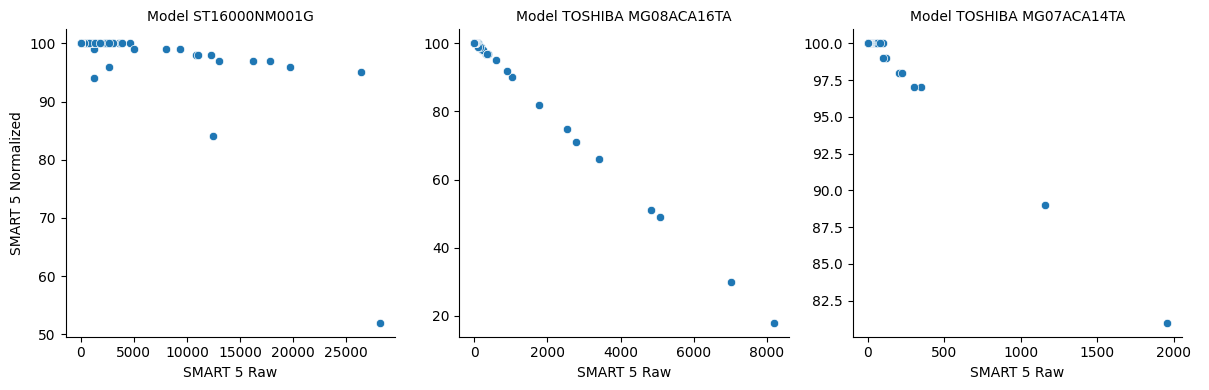

In [24]:
# Specify the models you are interested in
models_of_interest = ['TOSHIBA MG08ACA16TA', 'TOSHIBA MG07ACA14TA', 'ST16000NM001G']  # Replace with your specific models

# Filter the DataFrame to include only the specified models
filtered_df = df[df['model'].isin(models_of_interest)]

# Plotting using Seaborn FacetGrid
g = sns.FacetGrid(filtered_df, col='model', col_wrap=3, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x='smart_5_raw', y='smart_5_normalized')
g.set_axis_labels('SMART 5 Raw', 'SMART 5 Normalized')
g.set_titles(col_template='Model {col_name}')
g.add_legend()
plt.tight_layout()
plt.show()